In [236]:
import pandas as pd
import numpy as np
import os
from scipy import stats

pd.options.mode.chained_assignment = None

In [439]:
import seaborn as sns
import ptitprince as pt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load data

In [333]:
quest  = pd.read_csv('../subj-data/quest/SL_GERF_player_questionnaire.csv')
player = pd.read_csv('GERF_group_player_psi_data.csv').set_index('Player')
group  = pd.read_csv('GERF_group_means.csv').set_index('Group')

In [239]:
psi_names   = [ 'Psi_max', 'Psi_min', 'Psi_avg', 'Psi_std' ]
psych_names = [ 'DavisPerspective', 'WattsSelf', 'WattsOthers', 'WattsWorld', 'WattsTotal' ]

We exclude all manual emergence:

In [240]:
player = player[player.Manual == 0]

Recall buffer size and framerate

In [299]:
PSI_BUFFER_SIZE = 60
FRAMERATE       = 12

We read filtered data, but also unfiltered data, then apply the median filter for plotting so we have median absolute deviation as a measure of variability.

In [369]:
group_data = pd.read_csv(f"../experiment/groups_data.csv").set_index('Group')
group_data = group_data[group_data.Manual == 0]

START_THRESHOLD = FRAMERATE * 15

In [370]:
filt_psi = {}
for g in group_data[group_data.Psi_error == 0].index:
    start  = int(group_data.Filt_buffer[g] / 3 * 2 + START_THRESHOLD)
    length =  int(group_data.Duration[g]) - start + 1

    if os.path.exists(f"psi/{g}-psi.csv"):
        psis = pd.read_csv(f"psi/{g}-psi.csv")
        psis = psis[psis.type == 'Filtered']
        psis = psis[psis.frame >= start]
        psis = psis[psis.frame < start + length]
        filt_psi[g] = np.array(psis.psi)


In [371]:
raw_psi = {}
for g in group_data[group_data.Psi_error == 0].index:
    start  = int(group_data.Filt_buffer[g] / 3 * 2 + START_THRESHOLD)
    length =  int(group_data.Duration[g]) - start + 1

    if os.path.exists(f"psi/{g}-psi.csv"):
        psis = pd.read_csv(f"psi/{g}-psi.csv")
        psis = psis[psis.type == 'Unfiltered']
        psis = psis[psis.frame >= start]
        psis = psis[psis.frame < start + length]
        raw_psi[g] = np.array(psis.psi)



We pick the last 30 seconds of $\Psi$ data from all the games and temporally align them, so the peak matches in all the winning games.

In [372]:
def get_collapse_psi(df_dict, duration, groups = []):
    df = {}        
    if not groups:
        groups = list(df_dict.keys())
        
    for g in groups:
        if not np.isnan(df_dict[g]).all():
            df[g] = np.array(df_dict[g][-duration:])
        else:
            groups.remove(g)
                
    data = pd.DataFrame.from_dict(df, orient = 'index').transpose()
    data['timeindex'] = range(1 - duration, 1)
    data = data.melt(id_vars = 'timeindex')
    data['Emerged'] = data.variable.apply(lambda x: group.loc[x].Emerged)
    # do I need to remove manual?
    data['Manual']  = data.variable.apply(lambda x: group.loc[x].Manual)
    
    return data

In [373]:
NUM_SECONDS = 30

filt_align = get_collapse_psi(filt_psi, NUM_SECONDS * FRAMERATE) 
raw_align  = get_collapse_psi(raw_psi,  NUM_SECONDS * FRAMERATE) 

In [209]:
gs = collapse.variable.unique()
rolling_median = pd.DataFrame()

for g in gs:
    gdf = collapse[collapse.variable == g]
    mdf = gdf.rolling(psi_buffer_size + 1).median().dropna()
    mdf.timeindex += psi_buffer_size / 2
    mdf['variable'] = g
    rolling_median = pd.concat([rolling_median, mdf])

-----
# Paper figures

In [419]:
sns.set(font_scale = 1) 
sns.set_style('white')

In [431]:
cols = [ "#3d8af9", "#E6AA15", "#2940C0" , "#26262d" ]
pal  = sns.color_palette([mcolors.to_rgba(c) for c in cols ])
sns.set_palette(pal)
pal

[(0.23921568627450981, 0.5411764705882353, 0.9764705882352941),
 (0.9019607843137255, 0.6666666666666666, 0.08235294117647059),
 (0.1607843137254902, 0.25098039215686274, 0.7529411764705882),
 (0.14901960784313725, 0.14901960784313725, 0.17647058823529413)]

In [438]:
matplotlib.rcParams['font.family'] = 'serif'

## Figure 2 - $\Psi$

Raw values, averaged accross winning and losing groups

In [422]:
def plot_merged_vs_time(smelt, ylab, legend = False, num_seconds = NUM_SECONDS, framerate = FRAMERATE):
    plt.rcParams['figure.figsize'] = 8,4
    smelt = smelt[smelt.Manual == 0]
    
    ax = sns.lineplot(x="timeindex", y="value", hue="Emerged", style='Emerged', data=smelt, 
                 err_style="bars", markers = True, dashes = False, linewidth = .5, alpha = 0.95, legend = legend)
                #errorbar=("se", 2))
        
    ax.axhline(2.5, ls='--', color = cols[3], alpha = 0.5)
    ax.text(-num_seconds * framerate, 3, 'winning threshold', alpha = 0.5, fontsize = 11)
    
    
    times = smelt.timeindex.unique()
    time  = int(len(times) / FRAMERATE)
    
    plt.xticks(times[::int(FRAMERATE * 5)], range(-time, 0, 5), fontsize = 11)
    plt.xlabel('seconds before end of gameplay', fontsize = 11)
    
    plt.ylim(-12.5, 5)
    plt.ylabel(ylab, fontsize = 11)
    
    plt.tight_layout()

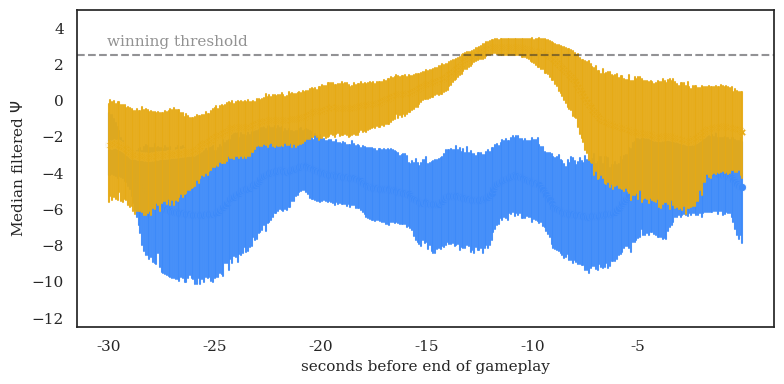

In [423]:
plot_merged_vs_time(filt_align, 'Median filtered $\\Psi$')

plt.savefig('../figs/fig2-1.svg')

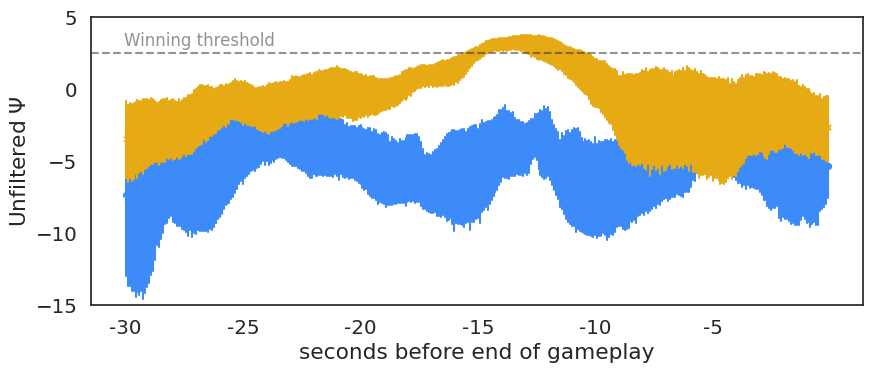

In [397]:
plot_merged_vs_time(raw_align, 'Unfiltered $\\Psi$')

## Figure 3 - Psychology

In [440]:
sns.set(font_scale = 1.3) 
sns.set_style('white')

In [441]:
sns.set_palette(pal)

In [442]:
matplotlib.rcParams['font.family'] = 'serif'

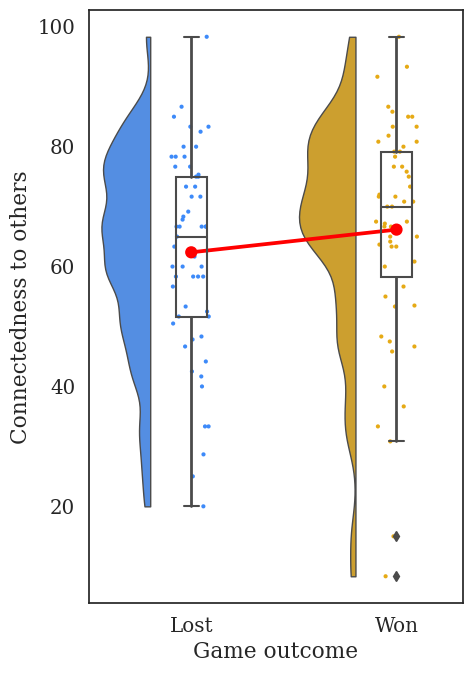

In [492]:
f, ax = plt.subplots(figsize=(5, 7))

pt.RainCloud(data = player, x = 'Emerged', y = 'WattsOthers', 
             palette = pal, bw = .2, jitter = 1, width_viol = .55, ax = ax, orient = 'v', pointplot = True)

plt.xlabel('Game outcome')
plt.xticks([0, 1], ['Lost', 'Won'])
plt.ylabel('Connectedness to others')

f.tight_layout()

plt.savefig('../figs/fig3-1.svg')

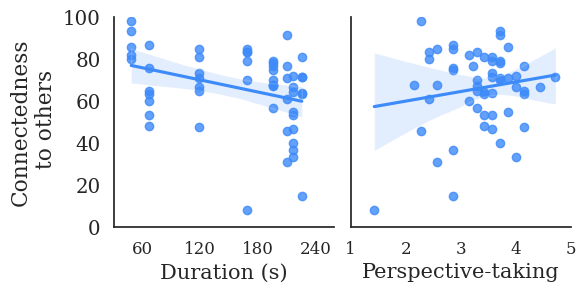

In [498]:
fig = sns.pairplot(player[player['Emerged'] == 1],
                    x_vars = [ 'Duration', 'DavisPerspective' ], y_vars = [ 'WattsOthers'],
                    kind="reg", height = 3,  palette = pal, 
                    diag_kind = None) # fix bug with dissapearing first graph

fig.axes[0,0].set_ylabel('Connectedness\n to others')
fig.axes[0,0].set_ylim((0, 100))

fig.axes[0,0].set_xlim((30, 260))
fig.axes[0,0].set_xlabel('Duration (s)', fontsize=15)
fig.axes[0,0].set_xticks([60, 120, 180, 240], [60, 120, 180, 240], fontsize=12)

fig.axes[0,1].set_xlim((1,5))
fig.axes[0,1].set_xlabel('Perspective-taking', fontsize=15);
fig.axes[0,1].set_xticks(range(1,6), range(1,6), fontsize=12)

fig.tight_layout()

plt.savefig('../figs/fig3-2.svg')

In [489]:
varnames = ['Perspective-\ntaking', 'Duration', 'Interaction' ]
slopes   = [ 4.04725, -0.07454, 0.14757 ]
stderrs  = [ 3.45242, 0.02946, 0.04921 ]
pvals    = [ 0.047506, 0.077450, 0.003818 ]

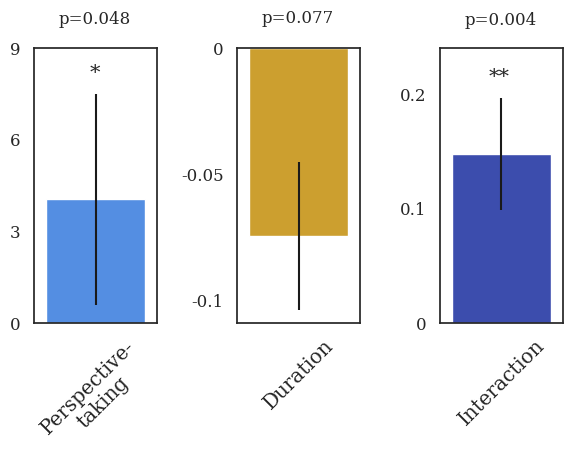

In [499]:
f, ax = plt.subplots(1, 3, figsize=(6, 5))


for i in range(3):
    sns.barplot(x = [varnames[i]], y = [slopes[i]], yerr = [stderrs[i]], ax = ax[i], color = cols[i])
    ax[i].tick_params(axis="x", rotation=45)

ax[0].set_yticks([0, 3, 6, 9], [0, 3, 6, 9], fontsize=12)
ax[0].text(-0.05, 8, '*', fontsize=15)
ax[0].text(-.3, 9.8, f'p={round(pvals[0],3)}', fontsize=12)

ax[2].set_ylim(-0.12, 0)
ax[1].set_yticks([0, -.05, -.1,], [0, -.05, -.1,], fontsize=12)
ax[1].text(-.3, 0.01, f'p={round(pvals[1],3)}', fontsize=12)

ax[2].set_ylim(0, .24)
ax[2].set_yticks([0, .1, .2], [0, .1, .2], fontsize=12)
ax[2].text(-0.1, .21, '**', fontsize=15)
ax[2].text(-.3, .26, f'p={round(pvals[2],3)}', fontsize=12)

plt.tight_layout()

plt.savefig('../figs/fig3-3.svg')

# Appendix plots

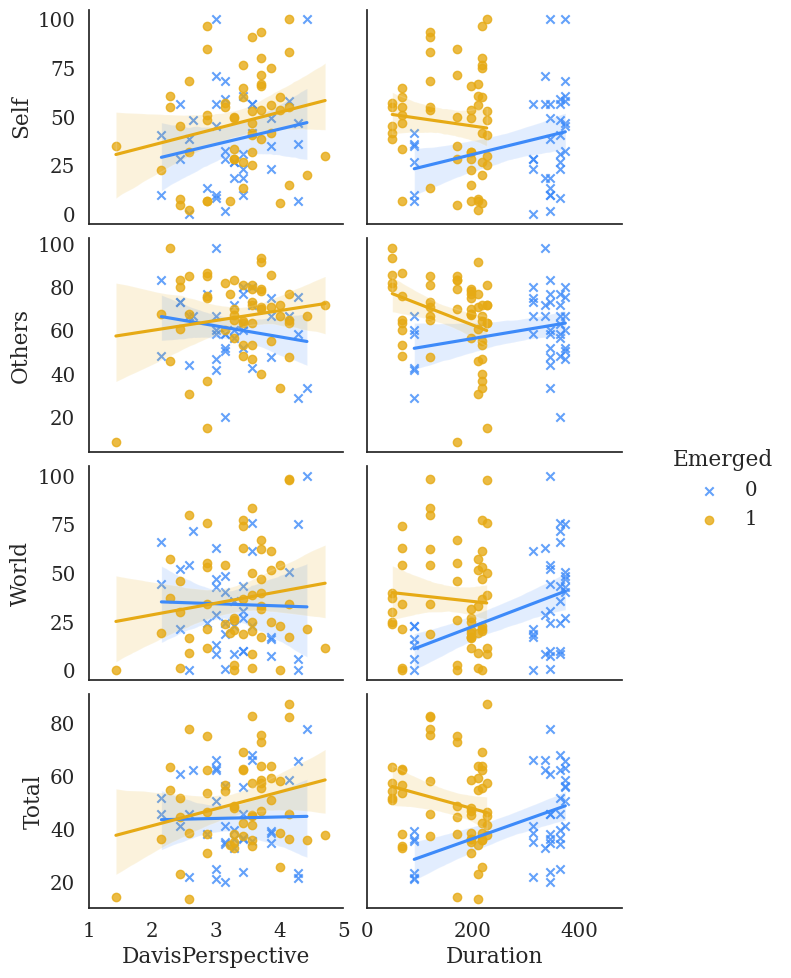

In [500]:
fig = sns.pairplot(player[player['Manual'] == 0],
                    y_vars = psych_names[1:5], x_vars = [ psych_names[0], 'Duration' ],
                    kind="reg", hue="Emerged",  markers = ['x', 'o'], palette = pal, 
                    diag_kind = None) # fix bug with dissapearing first graph

for ax, lbl in zip(fig.axes[:,0].flatten(), ['Self', 'Others', 'World', 'Total']):
    ax.set_ylabel(lbl)
    ax.set_facecolor('white')
    ax.set_xlim(1, 5)
for ax in fig.axes[:,1]:
    ax.set_xlim(0, 480)
fig.fig.set_size_inches(8,10)
#plt.xlabel('Perspective-taking')
fig.tight_layout()


May want to show the median and deviation from it, see this [SO](https://stackoverflow.com/questions/61436389/use-custom-function-median-absolute-deviation-in-pandas-transform)

In [362]:
def plot_groups_vs_time(smelt, ylab, groups = [], framerate = FRAMERATE):
    
    sns.set_palette('colorblind')

    plt.rcParams['figure.figsize'] = 8,4
    smelt = smelt[smelt.Manual == 0]

    if not groups:
        groups = smelt.variable.unique()

    f = plt.figure()
    ax = f.add_subplot(111)
    for g in groups:
        if int(smelt[smelt.variable == g].Emerged.unique()):
            col = cols[1]
        else:
            col = cols[0]
            
        sns.lineplot(x = smelt[smelt.variable == g].timeindex, 
                     y = smelt[smelt.variable == g].value,
                     color = col, ax = ax)

    ax.axhline(2.5, ls='--', color = cols[3], alpha = 0.5)
    ax.text(-num_seconds * framerate, 3, 'Winning threshold', alpha = 0.5, fontsize = 12)
    
    times = smelt.timeindex.unique()
    time  = int(len(times) / framerate)
    plt.xticks(times[::int(framerate * 5)], range(-time, 0, 5))
    plt.ylabel(ylab)
    plt.xlabel('seconds before end of gameplay')
    plt.tight_layout()

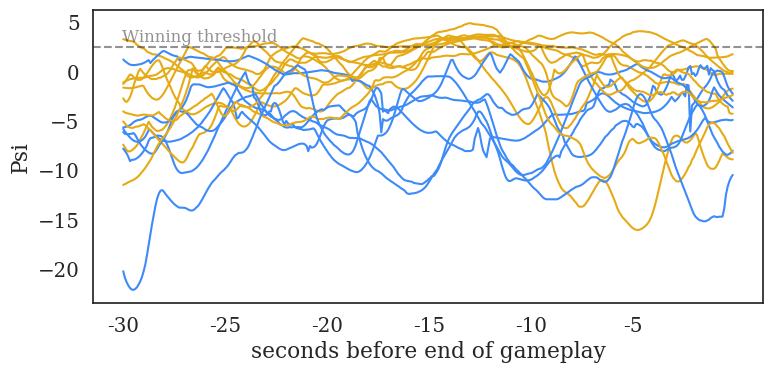

In [501]:
plot_groups_vs_time(raw_align, 'Psi')#, groups = ['A_4', 'A_10'])